In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# Import essential libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from sklearn.model_selection import train_test_split

# Check TensorFlow version and GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available: []


In [4]:
def load_dataset_from_folders(data_dir, img_size=(128, 128)):
    dataset = keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=img_size,
        batch_size=32,
        validation_split=0.3,  # Using 70% train, 30% for val+test
        subset="training",
        seed=42
    )
    
    val_dataset = keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=img_size,
        batch_size=32,
        validation_split=0.3,
        subset="validation",
        seed=42
    )
    
    return dataset, val_dataset

In [11]:
# Create CNN model with CORRECT number of output classes (17)
def create_jute_pest_cnn():
    model = tf.keras.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Second Convolutional Block  
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Classifier
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        # CORRECT: 17 output units for 17 classes
        layers.Dense(17, activation='softmax')
    ])
    return model

# Create the model
model = create_jute_pest_cnn()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 17)             │         4,369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,006,673 (64.88 MB)

 Trainable params: 17,006,673 (64.88 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
def create_improved_jute_pest_cnn():
    model = tf.keras.Sequential([
        # First Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block  
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fourth Convolutional Block
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Classifier
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(17, activation='softmax')
    ])
    return model

# Create the improved model
model = create_improved_jute_pest_cnn()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │    33,555,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 36,424,529 (138.95 MB)

 Trainable params: 36,419,537 (138.93 MB)

 Non-trainable params: 4,992 (19.50 KB)

In [21]:
# Load datasets directly
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/jute-pest/Jute_Pest_Dataset_organized/train",
    image_size=(128, 128),
    batch_size=32,
    validation_split=0.3,
    subset="training",
    seed=42,
    label_mode='int'
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/jute-pest/Jute_Pest_Dataset_organized/train", 
    image_size=(128, 128),
    batch_size=32,
    validation_split=0.3,
    subset="validation",
    seed=42,
    label_mode='int'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/jute-pest/Jute_Pest_Dataset_organized/test",
    image_size=(128, 128),
    batch_size=32,
    shuffle=False,
    label_mode='int'
)

print(f"Training batches: {len(train_dataset)}")
print(f"Validation batches: {len(val_dataset)}")
print(f"Test batches: {len(test_dataset)}")
print(f"Classes: {train_dataset.class_names}")
print(f"Number of classes: {len(train_dataset.class_names)}")

Found 5023 files belonging to 17 classes.
Using 3517 files for training.
Found 5023 files belonging to 17 classes.
Using 1506 files for validation.
Found 1103 files belonging to 17 classes.
Training batches: 110
Validation batches: 48
Test batches: 35
Classes: ['Beet Armyworm', 'Black Hairy', 'Cutworm', 'Field Cricket', 'Jute Aphid', 'Jute Hairy', 'Jute Red Mite', 'Jute Semilooper', 'Jute Stem Girdler', 'Jute Stem Weevil', 'Leaf Beetle', 'Mealybug', 'Pod Borer', 'Scopula Emissaria', 'Termite', 'Termite odontotermes (Rambur)', 'Yellow Mite']
Number of classes: 17


In [22]:
# Compile with Adam optimizer
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
# Train the model for 20 epochs
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    verbose=1
)

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 879s 8s/step - accuracy: 0.1307 - loss: 3.3758 - val_accuracy: 0.1368 - val_loss: 9.7117
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 870s 8s/step - accuracy: 0.2489 - loss: 2.5571 - val_accuracy: 0.2371 - val_loss: 2.8382
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 866s 8s/step - accuracy: 0.3346 - loss: 2.1922 - val_accuracy: 0.2430 - val_loss: 2.6240
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 865s 8s/step - accuracy: 0.3943 - loss: 1.9668 - val_accuracy: 0.4382 - val_loss: 1.9919
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 979s 8s/step - accuracy: 0.4908 - loss: 1.6483 - val_accuracy: 0.4880 - val_loss: 1.7248
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 924s 8s/step - accuracy: 0.5573 - loss: 1.4025 - val_accuracy: 0.3672 - val_loss: 2.1601
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 923s 8s/step - accuracy: 0.5933 - loss: 1.3516 - val_accuracy: 0.5511 - val_loss: 1.5108
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 921s 8s/step - accuracy: 0.6476 - loss: 1.1616 - val_accu

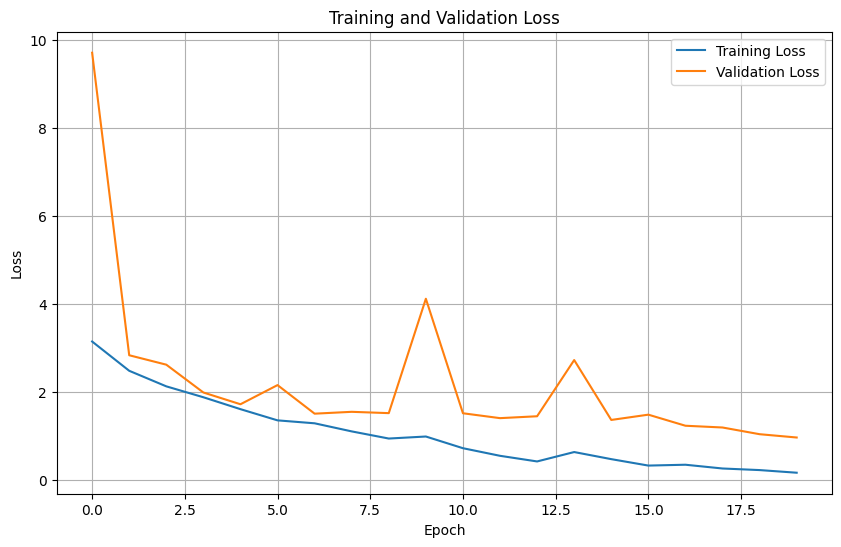

In [24]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

=== FINAL MODEL EVALUATION ON TEST SET ===
35/35 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6308 - loss: 1.4837
🎯 TEST Accuracy: 0.7226
🎯 TEST Loss: 1.0762
110/110 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.9907 - loss: 0.0283
📊 TRAIN Accuracy: 0.9920
Generating predictions for test set...


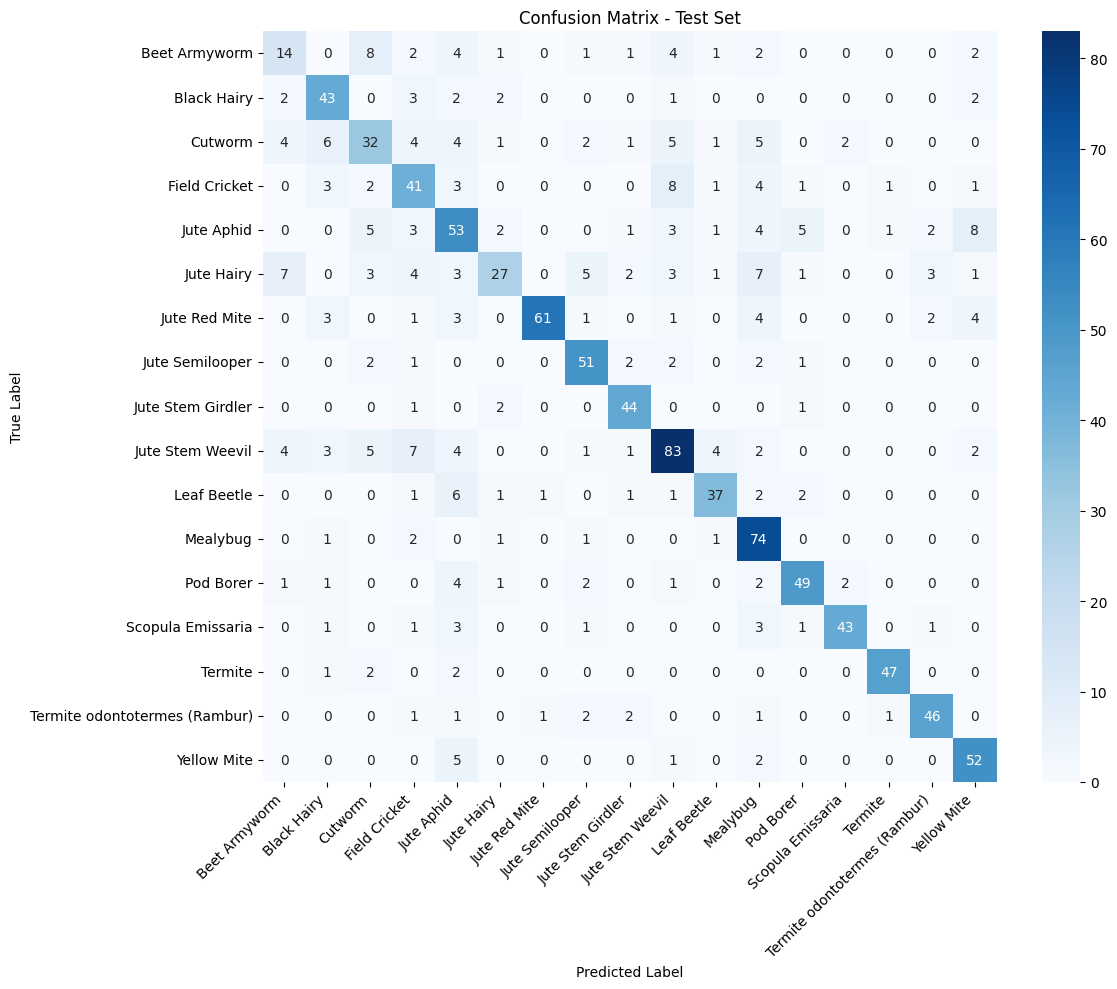

📊 Classification Report - Test Set:
                               precision    recall  f1-score   support

                Beet Armyworm     0.4375    0.3500    0.3889        40
                  Black Hairy     0.6935    0.7818    0.7350        55
                      Cutworm     0.5424    0.4776    0.5079        67
                Field Cricket     0.5694    0.6308    0.5985        65
                   Jute Aphid     0.5464    0.6023    0.5730        88
                   Jute Hairy     0.7105    0.4030    0.5143        67
                Jute Red Mite     0.9683    0.7625    0.8531        80
              Jute Semilooper     0.7612    0.8361    0.7969        61
            Jute Stem Girdler     0.8000    0.9167    0.8544        48
             Jute Stem Weevil     0.7345    0.7155    0.7249       116
                  Leaf Beetle     0.7872    0.7115    0.7475        52
                     Mealybug     0.6491    0.9250    0.7629        80
                    Pod Borer     0.8033

In [25]:
# Evaluate on UNSEEN test data
print("=== FINAL MODEL EVALUATION ON TEST SET ===")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"🎯 TEST Accuracy: {test_accuracy:.4f}")
print(f"🎯 TEST Loss: {test_loss:.4f}")

# Also get training accuracy for comparison
train_loss, train_accuracy = model.evaluate(train_dataset)
print(f"📊 TRAIN Accuracy: {train_accuracy:.4f}")

# Get predictions for confusion matrix and metrics
y_true = []
y_pred = []

print("Generating predictions for test set...")
for images, labels in test_dataset:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.class_names,
            yticklabels=train_dataset.class_names)
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Precision, Recall, F1-Score
print("📊 Classification Report - Test Set:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=train_dataset.class_names, digits=4))

# Test